In [1]:
%load_ext autoreload
%autoreload 2
import os, pickle, csv, itertools, shutil, random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchvision, torch
from torchvision import transforms
from omegaconf import OmegaConf as oc

%matplotlib inline
%config InlineBackend.figure_format='retina'

import utils.utils as utils
import evals.embed_evals as evals
import utils.plot_data as plot
import utils.gen_triplets as gen
import warnings
warnings.filterwarnings("ignore")

In [17]:
train_embeds = pickle.load(open("datasets/wv_3d/pseudo_label/train_features.pkl","rb"))
test_embeds = pickle.load(open("datasets/wv_3d/pseudo_label/test_features.pkl","rb"))
y_train = np.array([x[1] for x in torchvision.datasets.ImageFolder("datasets/wv_3d/pseudo_label/train")])
y_test = np.array([x[1] for x in torchvision.datasets.ImageFolder("datasets/wv_3d/pseudo_label/test")])

(array([  64.,  422.,   26.,    0.,    0.,    0.,  302.,  167.,  445.,
        2670.]),
 array([0.49   , 0.53975, 0.5895 , 0.63925, 0.689  , 0.73875, 0.7885 ,
        0.83825, 0.888  , 0.93775, 0.9875 ]),
 <BarContainer object of 10 artists>)

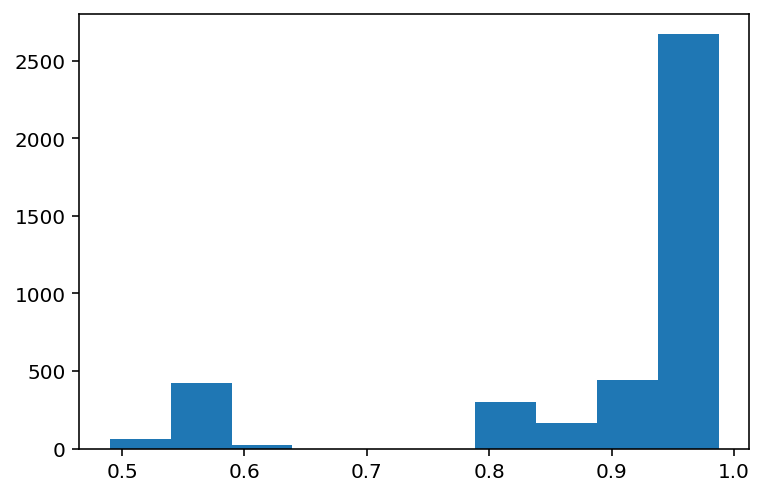

In [12]:
df = pd.read_csv("data_gen/grid.csv")
plt.hist(df["aligns"])

In [27]:
df.iloc[76]["weights"]

'(0, 1, 1, 8)'

In [26]:
np.where(df["aligns"]==0.59)

(array([ 76,  94,  97, 115, 141, 149, 167, 169, 170, 188, 214, 222, 242,
        243, 287, 295, 315, 316]),)

In [13]:
np.unique(df["aligns"])

array([0.49  , 0.5125, 0.5525, 0.555 , 0.5575, 0.56  , 0.5625, 0.565 ,
       0.5675, 0.57  , 0.5725, 0.575 , 0.5775, 0.58  , 0.5825, 0.585 ,
       0.5875, 0.59  , 0.5925, 0.8175, 0.82  , 0.8225, 0.825 , 0.8275,
       0.83  , 0.8325, 0.835 , 0.8375, 0.84  , 0.8425, 0.845 , 0.8475,
       0.875 , 0.88  , 0.8825, 0.885 , 0.8875, 0.895 , 0.8975, 0.9   ,
       0.905 , 0.9075, 0.91  , 0.9125, 0.915 , 0.9175, 0.92  , 0.9225,
       0.925 , 0.9275, 0.93  , 0.9325, 0.935 , 0.9375, 0.94  , 0.9425,
       0.945 , 0.9475, 0.95  , 0.9525, 0.955 , 0.9575, 0.96  , 0.9625,
       0.965 , 0.9675, 0.97  , 0.9725, 0.975 , 0.9775, 0.98  , 0.9825,
       0.985 , 0.9875])

In [24]:
evals.distorted_1nn(train_embeds, y_train, test_embeds, y_test, [1,1,0,0])

0.985

In [9]:
evals.distorted_1nn(train_embeds, y_train, test_embeds, y_test, [0,256,1,1])


0.54

In [25]:
evals.distorted_1nn(train_embeds, y_train, test_embeds, y_test, [1,0,1,1])

0.84

In [22]:
evals.distorted_1nn(train_embeds, y_train, test_embeds, y_test, [1,256,256,256])

0.92

In [21]:
evals.distorted_1nn(train_embeds, y_train, test_embeds, y_test, [0,1,1,1])


0.5625